## The metastable states of a peptide in water solution

In [2]:
# import libraries
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy import linalg
import matplotlib.pyplot as plt
from tqdm import tqdm


plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["figure.dpi"] = 150

COLORS = np.array(['red', 'blue', 'green', 'cyan', 'black', 'brown'])

def sorted_spectrum(matrix):
    eigenvalues, left_eigenvectors, right_eigenvectors = linalg.eig(matrix, left=True) # eigenvectors are the columns
    i = np.argsort(-eigenvalues)
    eigenvalues = np.real(eigenvalues[i])
    left_eigenvectors = np.real(left_eigenvectors[:, i])
    right_eigenvectors = np.real(right_eigenvectors[:, i])
    return eigenvalues, left_eigenvectors, right_eigenvectors

def pca(x: np.ndarray, dim: int = 'auto', variance_target: float = 0.99, normalize = False, plot=True):    
    centered_x = x - np.mean(x, axis=0)
    if normalize:
        centered_x /= np.std(x, axis=0)
    cov = (centered_x.T).dot(centered_x)/len(x)
    evalues, evectors, _ = sorted_spectrum(cov)
    expl_variance = np.append(0, np.cumsum(evalues / np.sum(evalues)))
    if plot:
        plt.plot(expl_variance, label = 'Cumulative explained variance', alpha = 0.8)
    if dim=='auto':
        dim = np.sum(expl_variance < variance_target)
        
    if plot:
        plt.axvline(x=dim, color = 'red', label = f"Dimensionality reduction: {x.shape[1]} -> {dim}", alpha = 0.8, linestyle='--')
        plt.axhline(y=expl_variance[dim], color = 'gray', label = f"Explained variance: {expl_variance[dim]:.3g}", alpha = 0.8, linestyle='--')
        plt.legend()
        plt.xlabel('PCs')
        plt.ylabel('Explained variance')
        plt.title('PCA')
        
    #print(f"Dimensionality reduction: {x.shape[1]} -> {dim}")
    #print(f"Explained variance: {expl_variance[dim]:.3f}")
    return centered_x.dot(evectors[:,:dim])

def show_transition_matrix(M):
    plt.imshow(M)
    if len(M) < 20:
        plt.xticks(np.arange(len(M)))
        plt.yticks(np.arange(len(M)))
    plt.colorbar()
    plt.title('Transition kernel')
    #print(np.round(M, 2))
  
def distance(x, y):
    return np.sum((x-y)**2., axis=-1)

def kmeans(*, X: np.ndarray, k: int):
    centers = X[np.random.choice(np.arange(len(X)), k, replace=False)] # Forgy method
    labels = np.zeros(len(X))
    old_labels = labels - 1
    while np.any(old_labels != labels):
        D = distance(np.expand_dims(X, 1), np.expand_dims(centers, 0))
        old_labels = labels
        labels = np.argmin(D, axis=1)
        centers = np.array([np.mean(X[labels==i], axis=0) for i in range(k)])
    labels -= np.min(labels)
    return (labels, centers)

In [3]:
# Download dataset
URL = "https://raw.githubusercontent.com/alexdepremia/Unsupervised-Learning-Datasets/main/high_variance_distances.dat.gz"
compressed_file_name = URL.split('/')[-1]
file_name = compressed_file_name[:-3]
if not os.path.exists('high_variance_distances.dat'):
    os.system(f'wget {URL}')
    os.system(f'gzip -d {compressed_file_name}')
    
# Load dataset
data = np.genfromtxt(file_name, delimiter=' ', dtype='float32')
data.shape

(7500, 177)

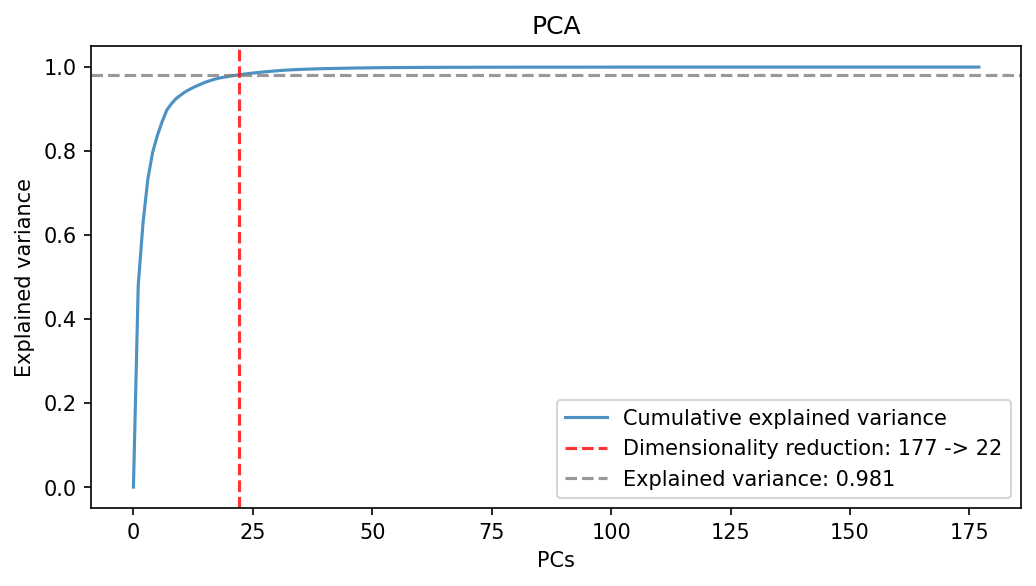

In [4]:
"""
Preliminary data processing

I chose to perform a preliminarly PCA for two reasons:
    1. I can significantly reduce the number of dimensions keeping the explained variance close the total, so it's "free"
    2. My kmeans clustering is not really memory efficient (also my laptop has not much RAM), so it's sensible to the dimensionality of the dataset
"""

CENTER = True
NORMALIZE = False
PCA_VARIANCE_TARGET = 0.98

X = data

if CENTER:
    X -= X.mean(axis=0)
if NORMALIZE:
    X /= X.std(axis=0)
if PCA_VARIANCE_TARGET:
    X = pca(X, variance_target = PCA_VARIANCE_TARGET)

### Find the microstates by a cluster analysis performed with k-means or k-medoids.

In [5]:
N_CLUSTERS = 75
state, centers = kmeans(X=X, k=N_CLUSTERS)

### Choose a time lag and estimate the transition matrix between each pair of clusters

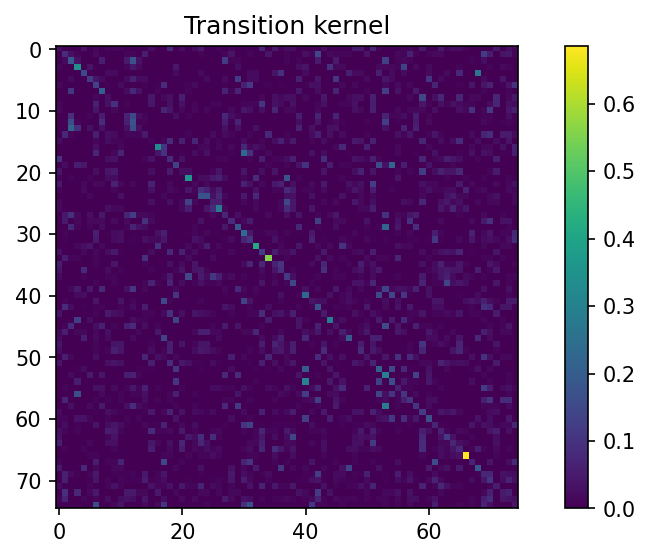

In [6]:
TIME_LAG = 10

def get_transition_matrix(states: np.ndarray, time_lag: int) -> np.ndarray:
    frequency_matrix = confusion_matrix(states[:-time_lag], states[time_lag:])
    transition_matrix = frequency_matrix / np.expand_dims(frequency_matrix.sum(axis=1),1)
    np.testing.assert_almost_equal(transition_matrix.sum(axis=1), np.ones(len(transition_matrix)))
    #if not (transition_matrix>0).all():
    #    print(f'Warning: there are {np.sum(transition_matrix<=0)} null entries')
    return transition_matrix
  
transition_matrix = get_transition_matrix(state, TIME_LAG)
show_transition_matrix(transition_matrix)

### By analyzing the spectrum choose an appropriate number of Markov states. Find the Markov states by inspecting the sign of the eigenvectors.

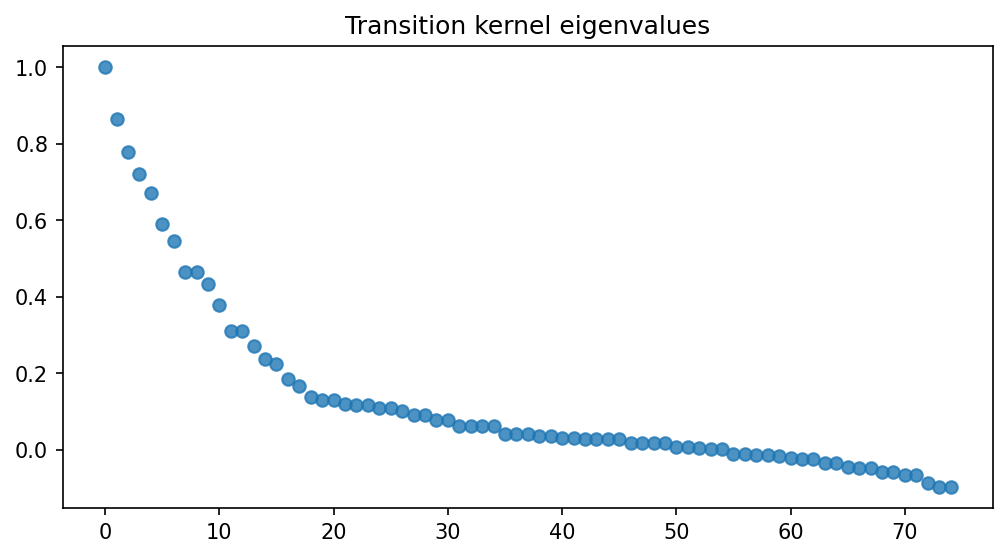

In [7]:
eigenvalues, left_eigenvectors, right_eigenvectors = sorted_spectrum(transition_matrix)
equilibrium = left_eigenvectors[:, 0] / left_eigenvectors[:, 0].sum()

np.testing.assert_almost_equal(eigenvalues[0], 1)
np.testing.assert_allclose(equilibrium.dot(transition_matrix), equilibrium)
np.testing.assert_almost_equal((left_eigenvectors.sum(axis=0)[1:])**2, 0.)

_ = plt.scatter(np.arange(len(eigenvalues)), eigenvalues, alpha = 0.8)
_ = plt.title('Transition kernel eigenvalues')

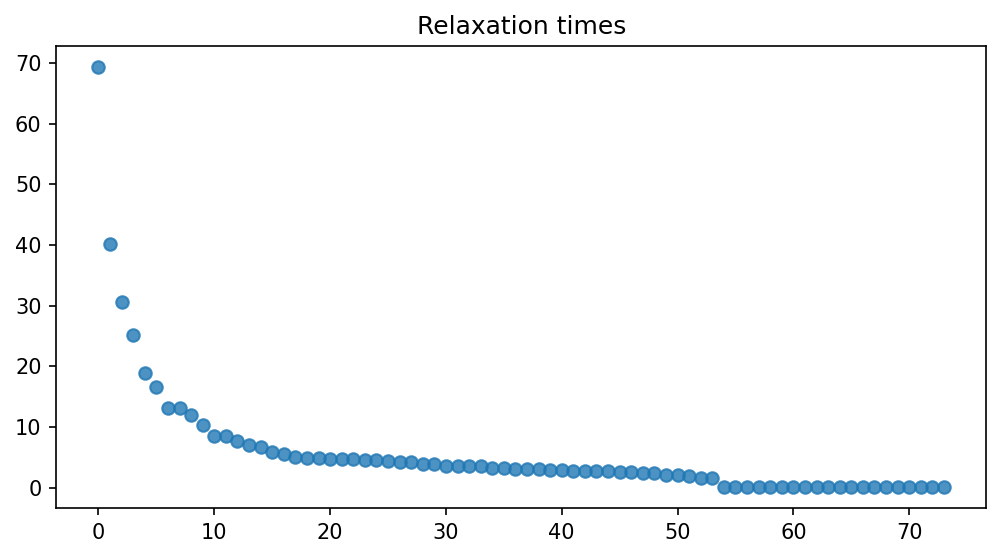

In [8]:
def get_relaxation_time(v, time_lag):
    return -time_lag/np.log(np.where(v>0, v, 1e-99))

relaxation_times = get_relaxation_time(eigenvalues[1:], TIME_LAG)
_ = plt.scatter(np.arange(len(relaxation_times)), relaxation_times, alpha = 0.8)
_ = plt.title('Relaxation times')

In [9]:
def to_markov_state(s: np.ndarray, l_eigvectors: np.ndarray, level: int =1):
    """
    Crazy one liner:
        - for each eigenvectors extract > 0 information, so turn eigenvetors matrix into binary (1, 0)
        - each row is interpreted as a binary number, so converted to decimal
        - apply modulo (2^level) in order to consider only first level eigenvectors
    """
    markov_states_map = np.sum(2**np.arange(l_eigvectors.shape[1]-1) * (l_eigvectors[:,1:]>0)*1, axis=1)%(2**level)
    return markov_states_map, markov_states_map[s]

markov_states_map, markov_state = to_markov_state(s=state, l_eigvectors=left_eigenvectors, level=1)

markov_states_dict = {mstate : list(np.arange(len(markov_states_map))[markov_states_map==mstate]) for mstate in np.unique(markov_states_map)}

print(f"markov_states_dict = ")
for k,v in markov_states_dict.items():
    print(f"\t{k}: {v}")

markov_states_dict = 
	0: [0, 4, 6, 8, 9, 10, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 30, 31, 32, 33, 35, 36, 37, 38, 41, 43, 47, 48, 49, 51, 59, 61, 62, 63, 64, 65, 66, 67, 68, 71, 74]
	1: [1, 2, 3, 5, 7, 11, 12, 13, 14, 19, 27, 28, 29, 34, 39, 40, 42, 44, 45, 46, 50, 52, 53, 54, 55, 56, 57, 58, 60, 69, 70, 72, 73]


[[0.9  0.1 ]
 [0.12 0.88]]


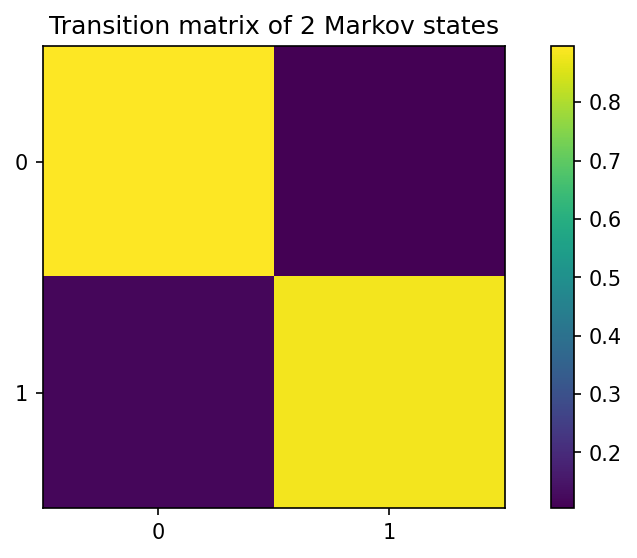

In [10]:
_, markov_state = to_markov_state(s=state, l_eigvectors=left_eigenvectors, level=1)
tm = get_transition_matrix(markov_state, time_lag = TIME_LAG)
show_transition_matrix(tm)
_ = plt.title(f"Transition matrix of {len(set(markov_state))} Markov states")
print(np.round(tm, 2))

[[0.73 0.03 0.2  0.04]
 [0.07 0.75 0.03 0.15]
 [0.24 0.02 0.62 0.13]
 [0.02 0.06 0.1  0.82]]


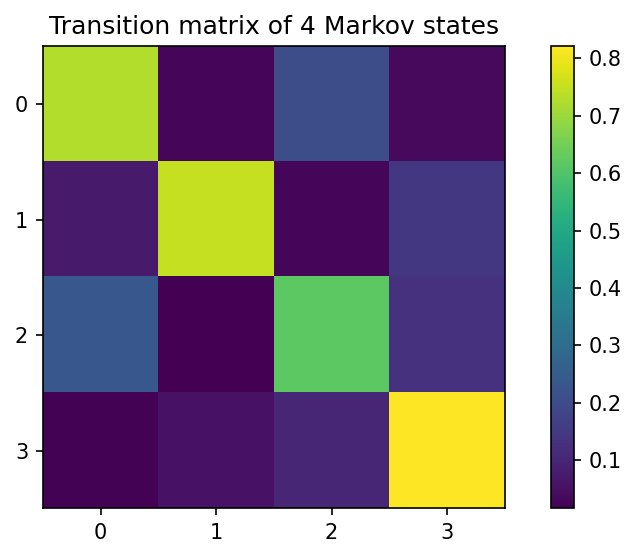

In [11]:
_, markov_state = to_markov_state(s=state, l_eigvectors=left_eigenvectors, level=2)
tm = get_transition_matrix(markov_state, time_lag = TIME_LAG)
show_transition_matrix(tm)
_ = plt.title(f"Transition matrix of {len(set(markov_state))} Markov states")
print(np.round(tm, 2))

### Perform a dimensional reduction with a method of your choice, retaining only two coordinates, and visualize the Markov states in the space of these coordinates.

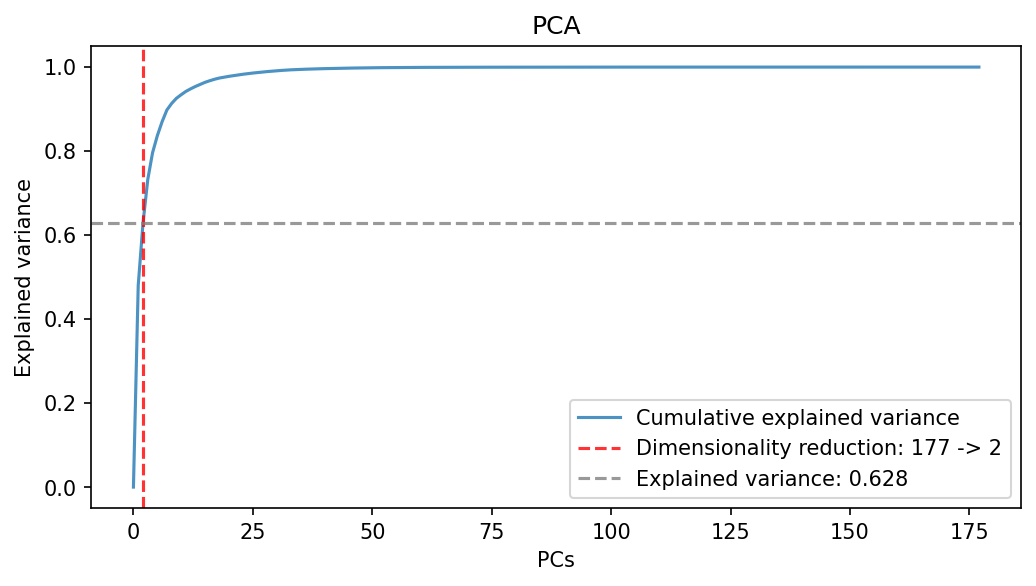

In [12]:
compressed_data = pca(data, dim=2, normalize=NORMALIZE)

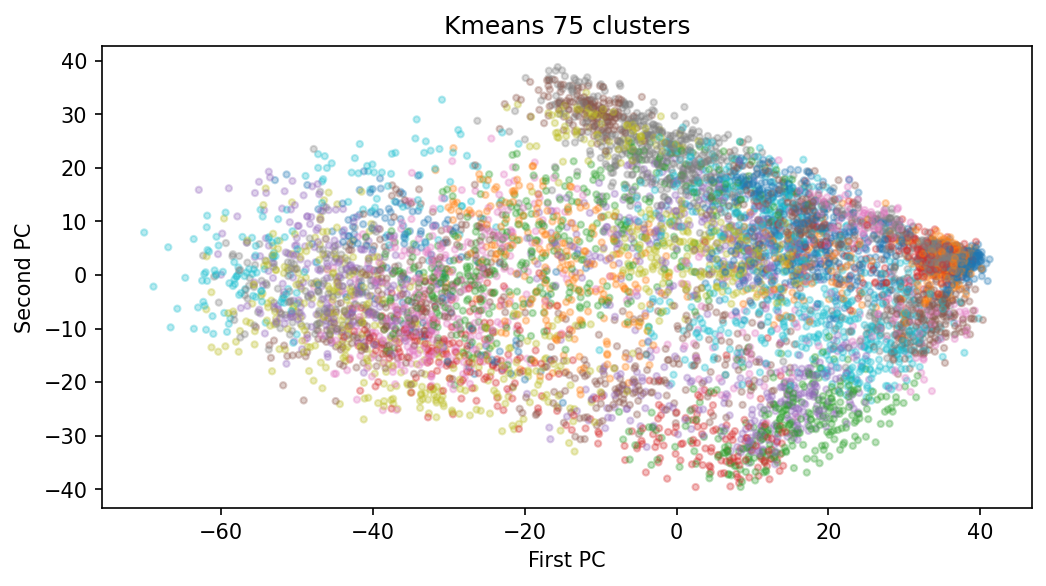

In [13]:
plt.scatter(compressed_data[:,0], compressed_data[:,1], c = state, alpha=0.3, cmap = 'tab10', marker = '.')
plt.xlabel('First PC')
plt.ylabel('Second PC')
_ = plt.title(f'Kmeans {N_CLUSTERS} clusters')

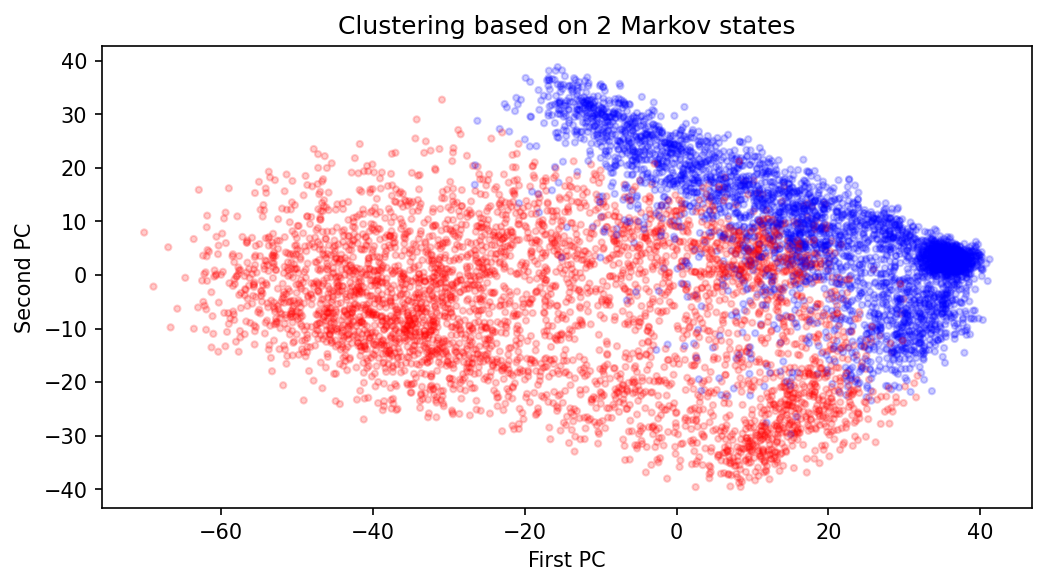

In [14]:
_, markov_state = to_markov_state(s=state, l_eigvectors=left_eigenvectors, level=1)
plt.scatter(compressed_data[:,0], compressed_data[:,1], c = COLORS[markov_state], alpha=0.2, marker = '.')
plt.xlabel('First PC')
plt.ylabel('Second PC')
_ = plt.title(f'Clustering based on {len(set(markov_state))} Markov states')

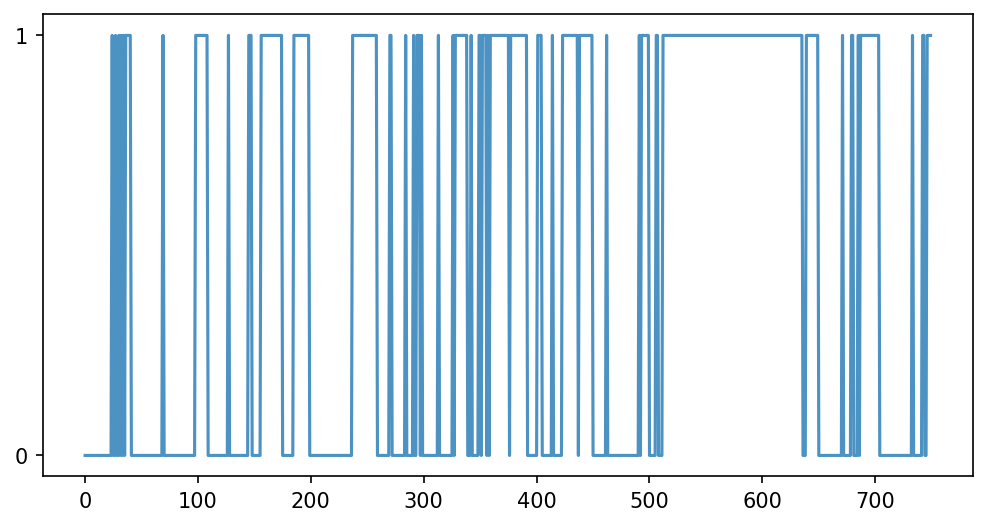

In [15]:
def transitions_plot(states, time_lag):
    _ = plt.plot(states[::time_lag], '-', alpha = 0.8)
    _ = plt.yticks(np.arange(1 + np.max(states)))
    
transitions_plot(markov_state, TIME_LAG)

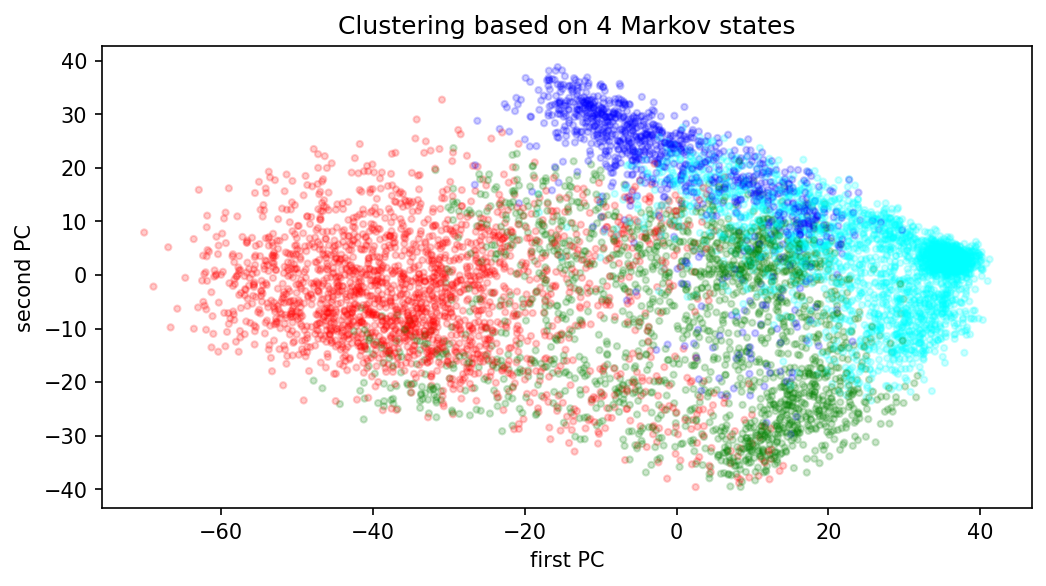

In [16]:
_, markov_state = to_markov_state(s=state, l_eigvectors=left_eigenvectors, level=2)

plt.scatter(compressed_data[:,0], compressed_data[:,1], c = COLORS[markov_state], alpha=0.2, marker = '.')
plt.xlabel('first PC')
plt.ylabel('second PC')
_ = plt.title(f'Clustering based on {len(set(markov_state))} Markov states')

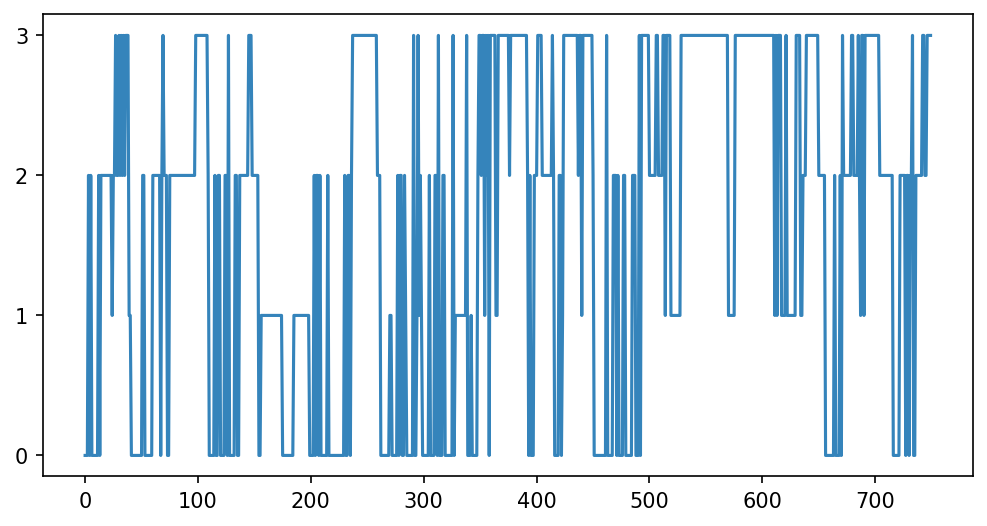

In [17]:
plt.plot(markov_state[::TIME_LAG], '-', alpha = 0.9)
_ = plt.yticks(np.arange(1 + np.max(markov_state)))

### Discuss the stability of the results with respect to the meta-parameters of the approach, in particular, the time lag τ and the number of clusters.

In [18]:
def Markov_state_modelling(X, time_lag, n_clusters):
    s, _ = kmeans(X=X, k=n_clusters)
    
    transition_matrix = get_transition_matrix(s, time_lag)
    eigenvalues, left_eigenvectors, _ = sorted_spectrum(transition_matrix)

    relaxation_times = get_relaxation_time(eigenvalues[1:], time_lag)
    _ = plt.scatter(np.arange(len(relaxation_times)), relaxation_times, alpha=0.8)
    plt.title('Relaxation times')
    plt.show()
    
    compressed_x = pca(X, 2, plot=False)
    print(s)
    
    for level in (1, 2):
        _, markov_state = to_markov_state(s, left_eigenvectors, level=level)
        tm = get_transition_matrix(markov_state, time_lag = TIME_LAG)
        show_transition_matrix(tm)
        _ = plt.title(f"Transition matrix of {len(set(markov_state))} Markov states")
        plt.show()
        print(np.round(tm, 2))

        plt.scatter(compressed_x[:,0], compressed_x[:,1], c = COLORS[markov_state], alpha=0.2, marker = '.')
        plt.xlabel('First PC')
        plt.ylabel('Second PC')
        _ = plt.title(f'Clustering based on {len(set(markov_state))} Markov states')
        plt.show()
        
        transitions_plot(markov_state, time_lag)
        plt.show()

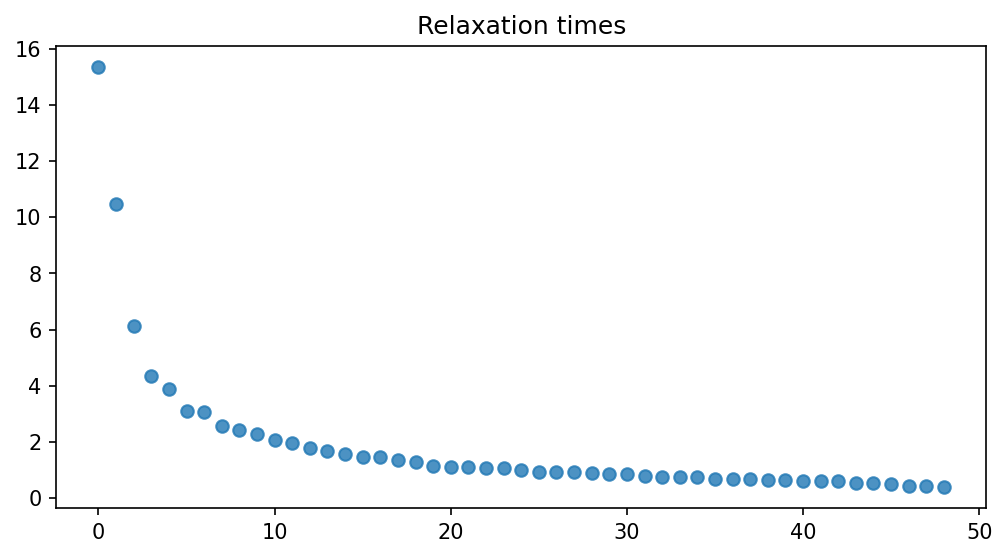

[23 33 23 ... 34 34 34]


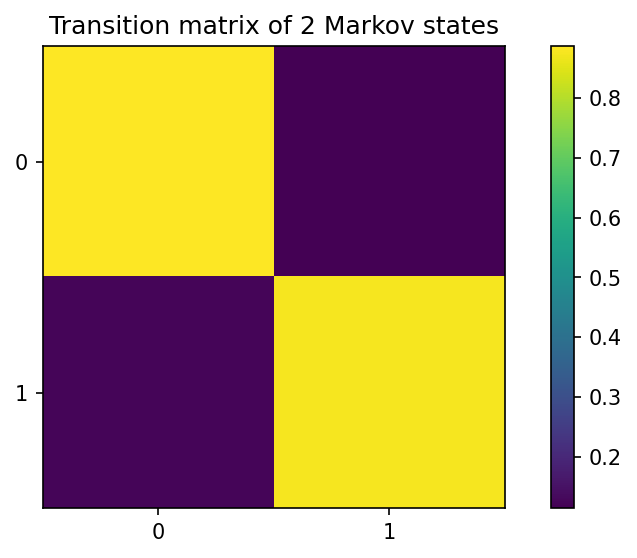

[[0.89 0.11]
 [0.12 0.88]]


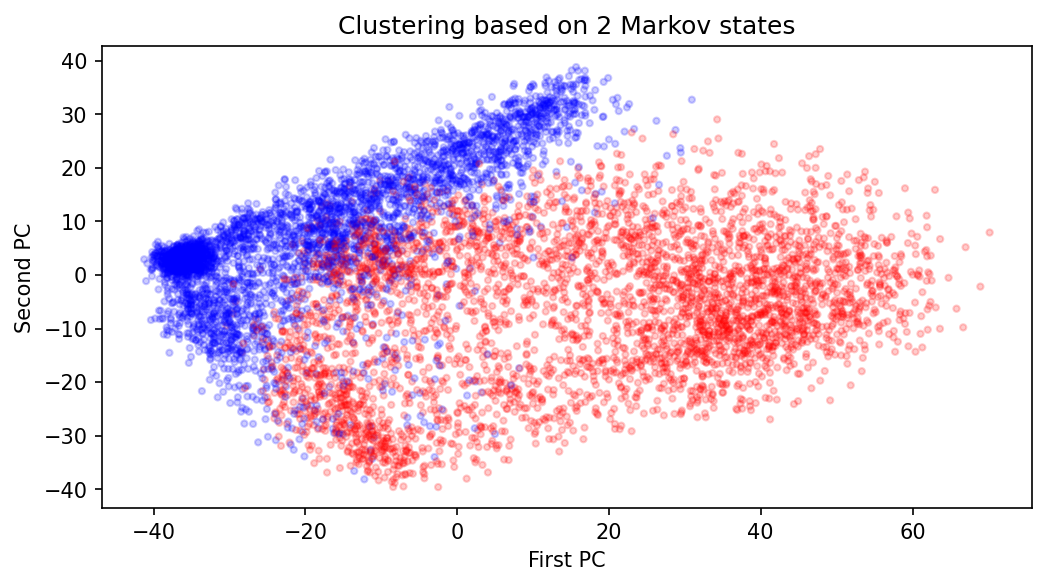

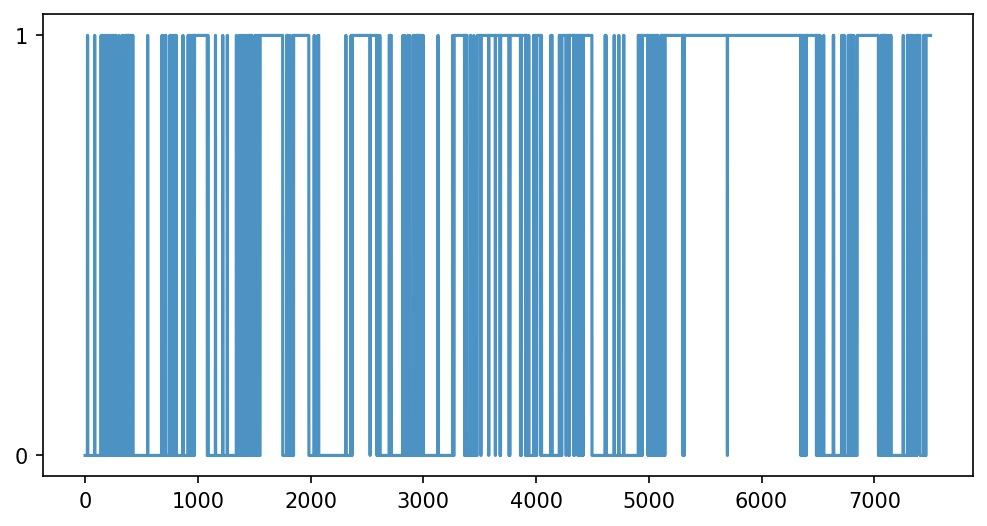

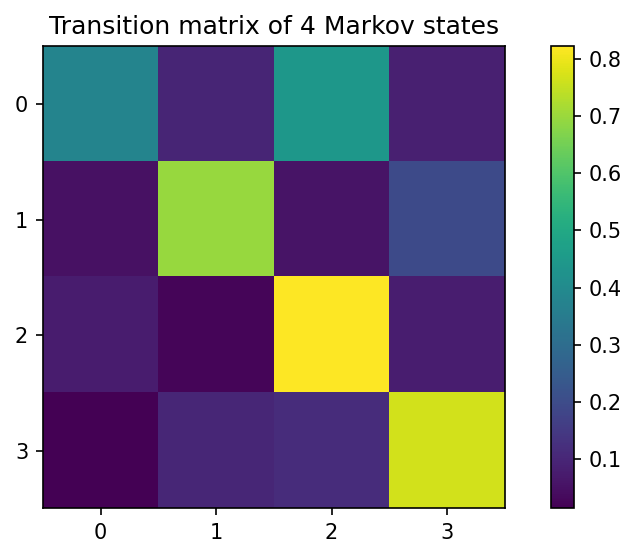

[[0.38 0.1  0.44 0.08]
 [0.05 0.7  0.06 0.2 ]
 [0.08 0.02 0.82 0.08]
 [0.01 0.1  0.12 0.77]]


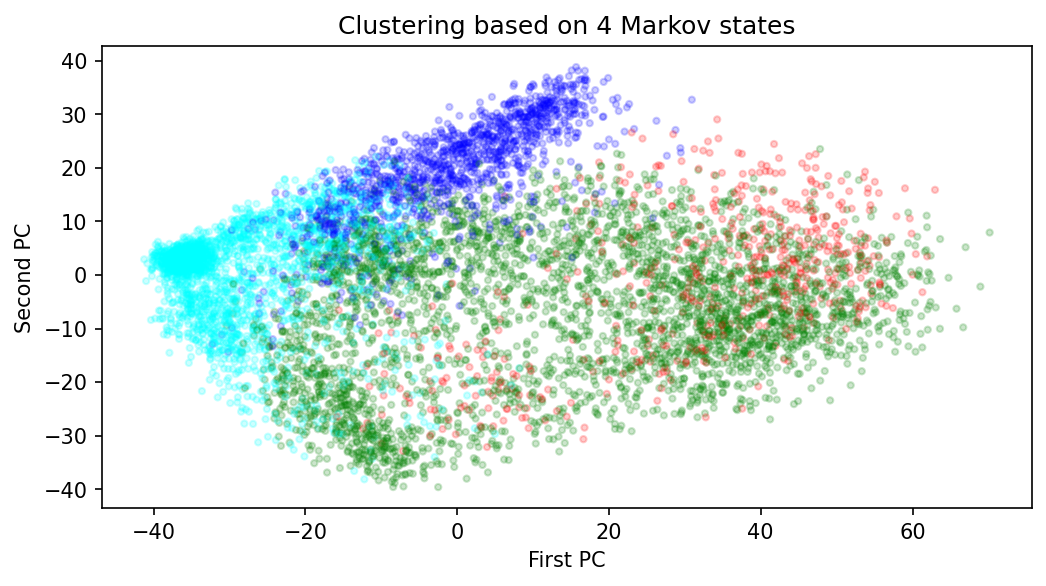

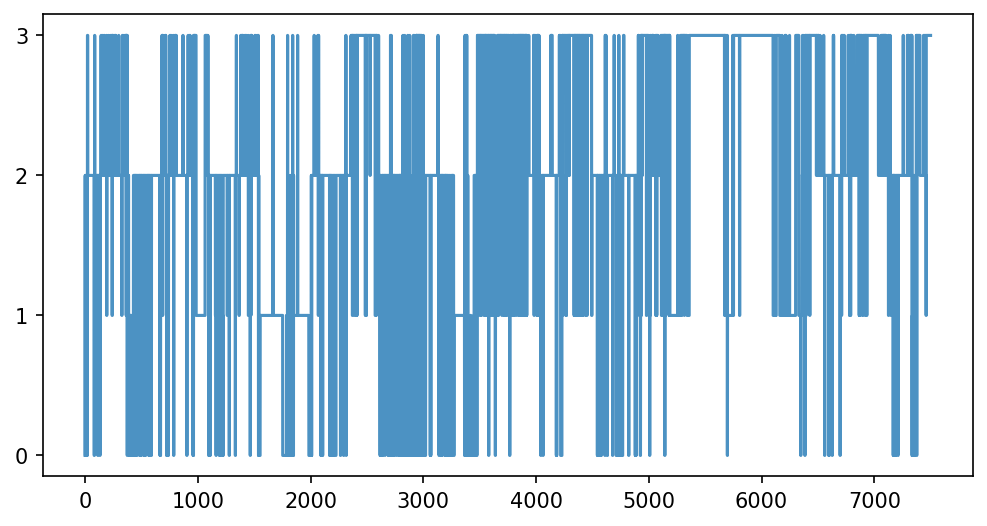

In [19]:
# Small time-lag
Markov_state_modelling(X, time_lag = 1, n_clusters = 50)

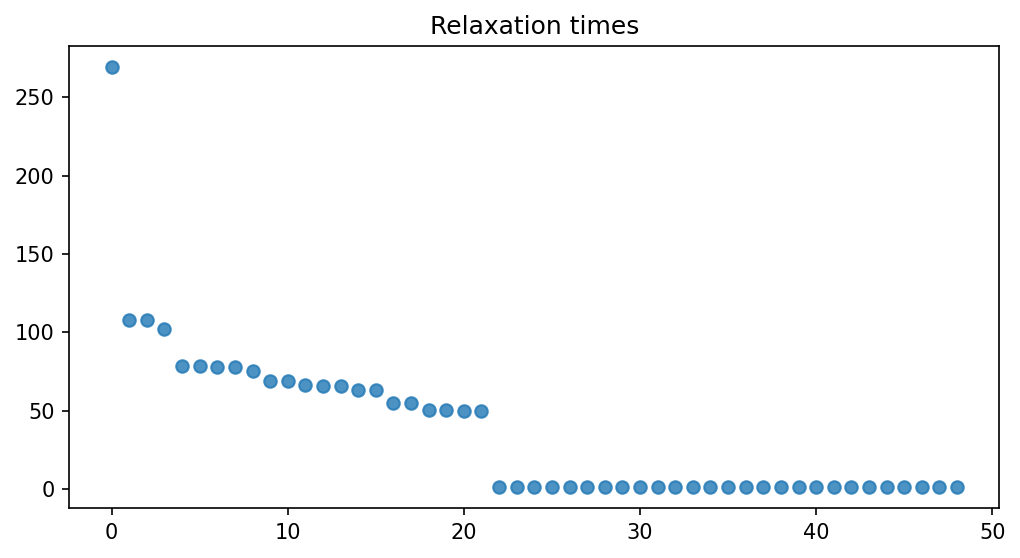

[35 47 35 ... 39 39 39]


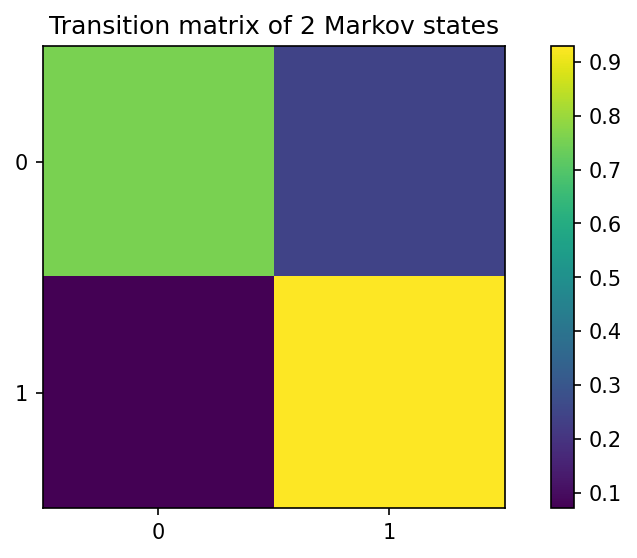

[[0.76 0.24]
 [0.07 0.93]]


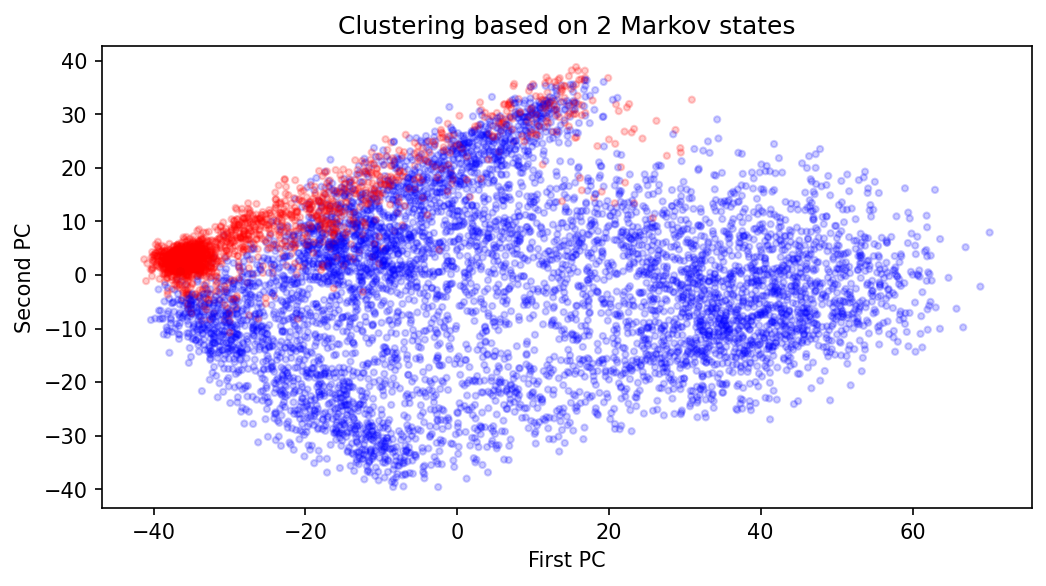

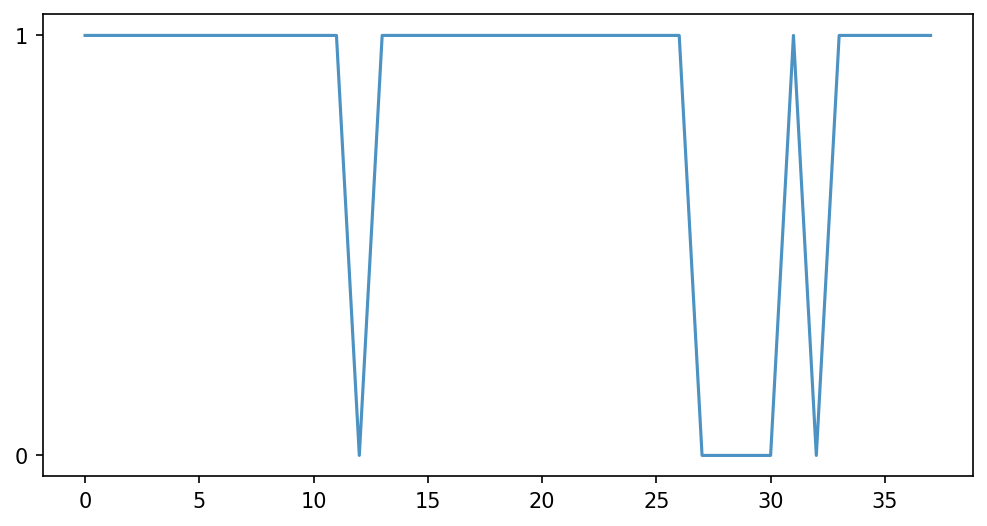

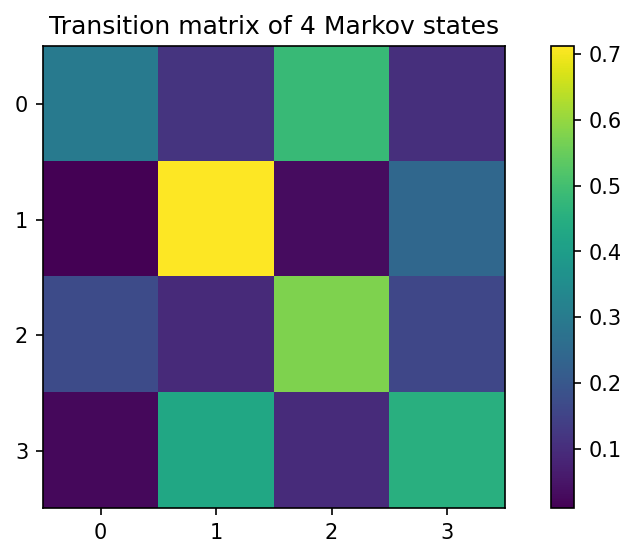

[[0.3  0.11 0.48 0.11]
 [0.01 0.71 0.03 0.25]
 [0.17 0.09 0.58 0.16]
 [0.02 0.43 0.1  0.45]]


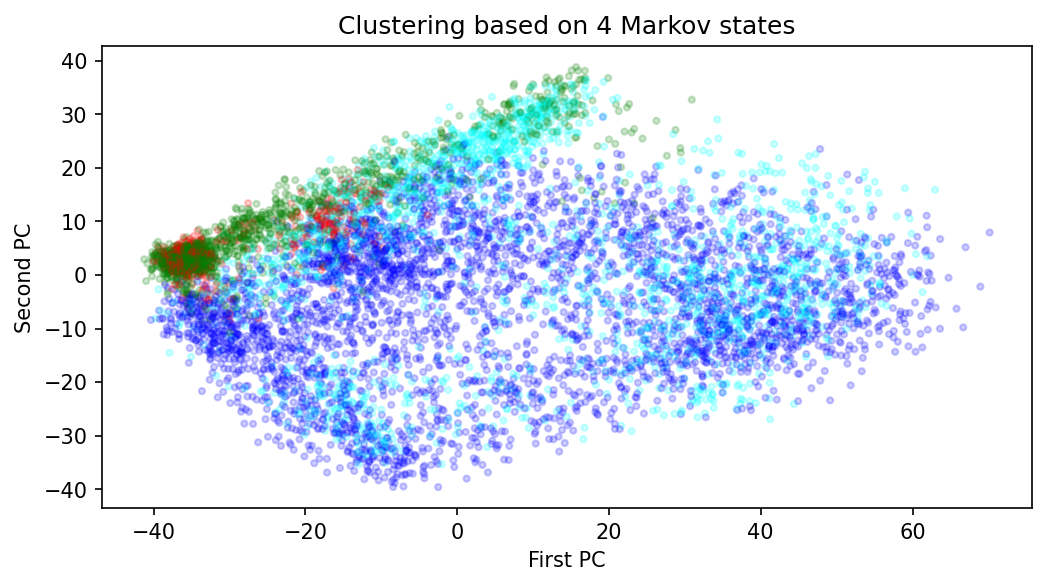

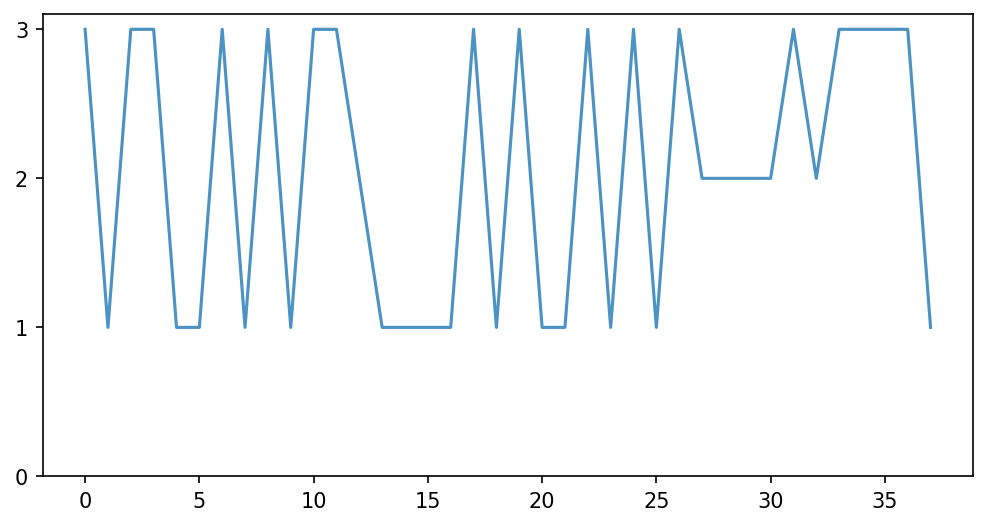

In [20]:
# Large time-lag
Markov_state_modelling(X, time_lag = 200, n_clusters = 50)

## Dependence on time lag and number of clusters

#### Number of clusters
It's necessary to have at least a certain number of clusters in order to obtain stable results, approximately at least 20. If clusters are too large, the estimation of the transition kernel could be less meaningful, since the state could be not informative enough to allow the system to be Markovian. If there are too many clusters, there are not enough observations for estimating the transition kernel.

#### Time lag
When the time lag is small, the estimated transition kernel is almost diagonal. This makes the eigenvalues more similar between each other and there are no clear jumps between relaxation times. Usually Markov states extracted from the second (and eventualy also third) eigenvectors are stable (almost diagonal transition matrix)

When the time lag is large, the transition probability is less concentrated on the diagonal. This makes the matrix more suitable for a decomposition: eigenvalues could be more different between each other, then often there are clear jumps between relaxation times. Usually Markov states extracted from the second (and eventualy also third) eigenvectors are less stable than the previous case.

From visual inspection, it seems the 2 markov states extracted from the second eigenvector are similar when the time-lag varies. This is not true when analysing more Markov states, probably since relaxation times after the first one are more sensible to the time lag. When taking a smaller time-lag they are more meaningful.


100%|██████████| 500/500 [00:13<00:00, 37.41it/s]


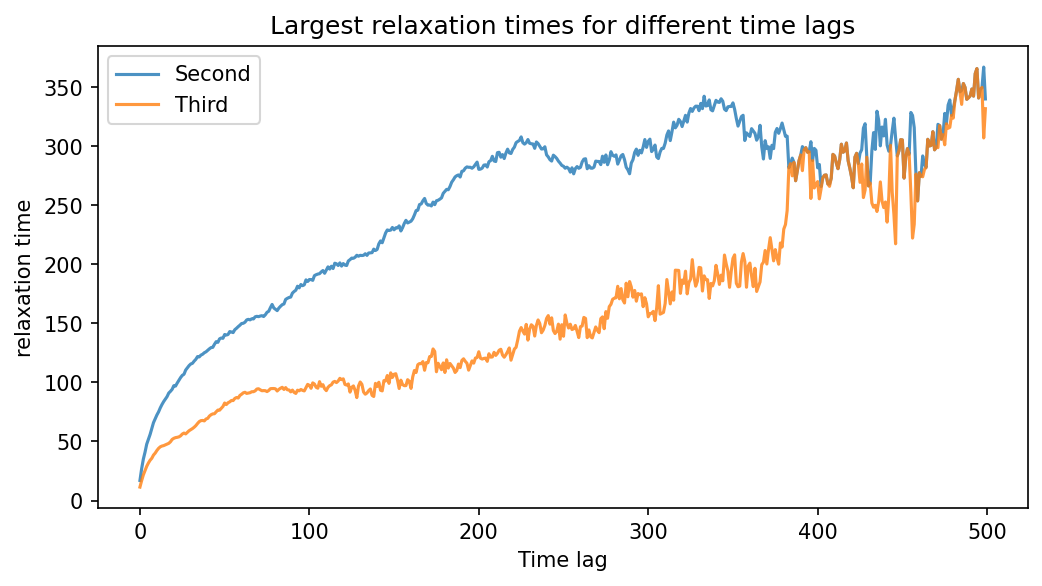

In [21]:
# time lag and largest relaxation times

def get_relaxation_times(state, lags, eig_number):
    return [get_relaxation_time(sorted_spectrum(get_transition_matrix(state, lag))[0][eig_number], lag) for lag in tqdm(range(1, lags+1))]

relaxation_times_1 = get_relaxation_times(state, lags = 500, eig_number = 1)
relaxation_times_2 = get_relaxation_times(state, lags = 500, eig_number = 2)

plt.plot(relaxation_times_1, alpha = 0.8, label = 'Second')
plt.plot(relaxation_times_2, alpha = 0.8, label = 'Third')
plt.legend()
plt.xlabel("Time lag")
plt.title("Largest relaxation times for different time lags")
_ = plt.ylabel("relaxation time")

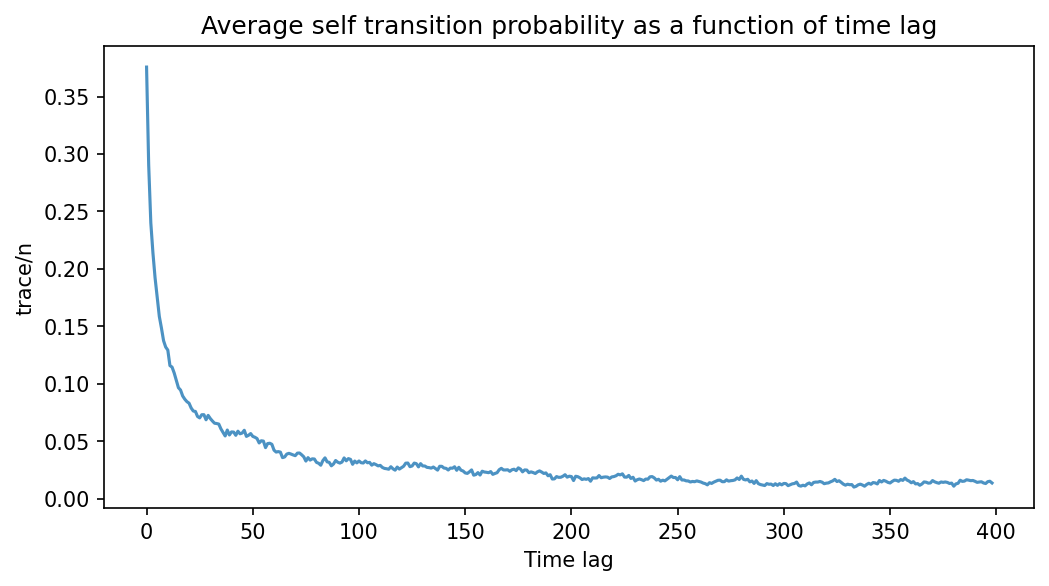

In [22]:
# Time lag and self transition probability
traces = [np.trace(get_transition_matrix(state, lag))/N_CLUSTERS for lag in range(1, 400)]
plt.plot(traces, alpha = 0.8)
plt.title("Average self transition probability as a function of time lag")
_ = plt.ylabel("trace/n")
_ = plt.xlabel("Time lag")

  3%|▎         | 12/400 [00:00<00:07, 52.86it/s]

100%|██████████| 400/400 [00:07<00:00, 57.10it/s]


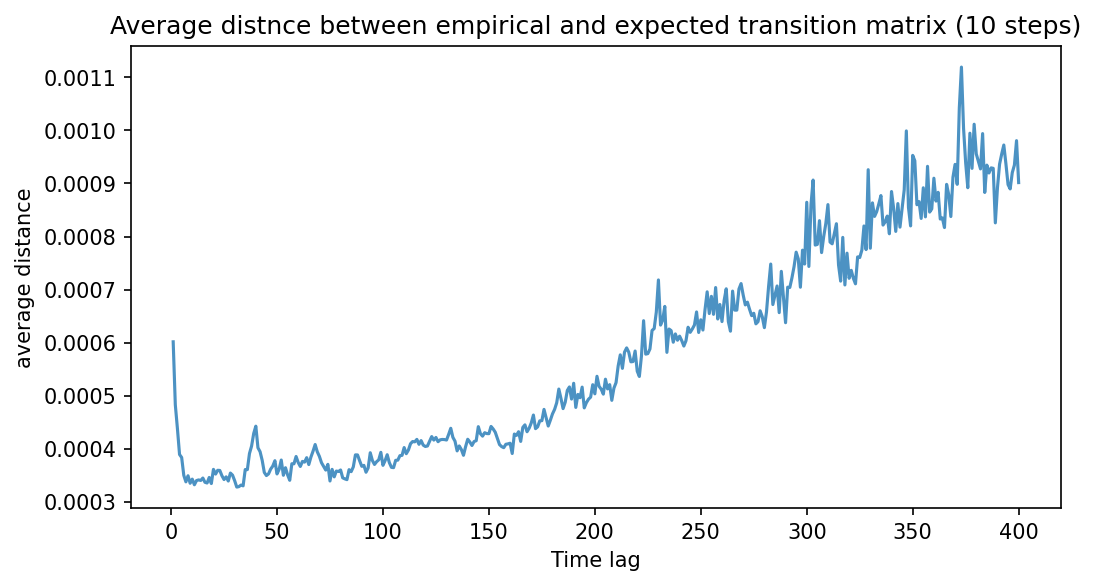

In [23]:
# Time lag and markovianity

def average_Dkl(A, B):
    Dkl = np.sum(A * np.log(1e-4 + A/(B + 1e-6)), axis = 1) + np.sum(B * np.log(1e-4 + B/(A + 1e-6)), axis = 1)
    return np.mean(Dkl)

def l2(A, B):
    return np.mean((A - B)**2)

def markovianity_test(states, lags, steps=2, sm_distance = l2):
    adkl = np.zeros(lags)
    for l in tqdm(range(1, lags+1)):
        tm = get_transition_matrix(states, l)
        tm_pow_expected = np.linalg.matrix_power(tm, steps)
        tm_pow_empirical = get_transition_matrix(states, l*steps)
        adkl[l-1] = sm_distance(tm_pow_expected, tm_pow_empirical)
    return adkl

STEPS = 10
average_distance = markovianity_test(state, 400, steps=STEPS)
plt.plot(np.arange(len(average_distance))+1, average_distance, alpha = 0.8)
plt.xlabel("Time lag")
plt.ylabel("average distance")
_ = plt.title(f"Average distnce between empirical and expected transition matrix ({STEPS} steps)")

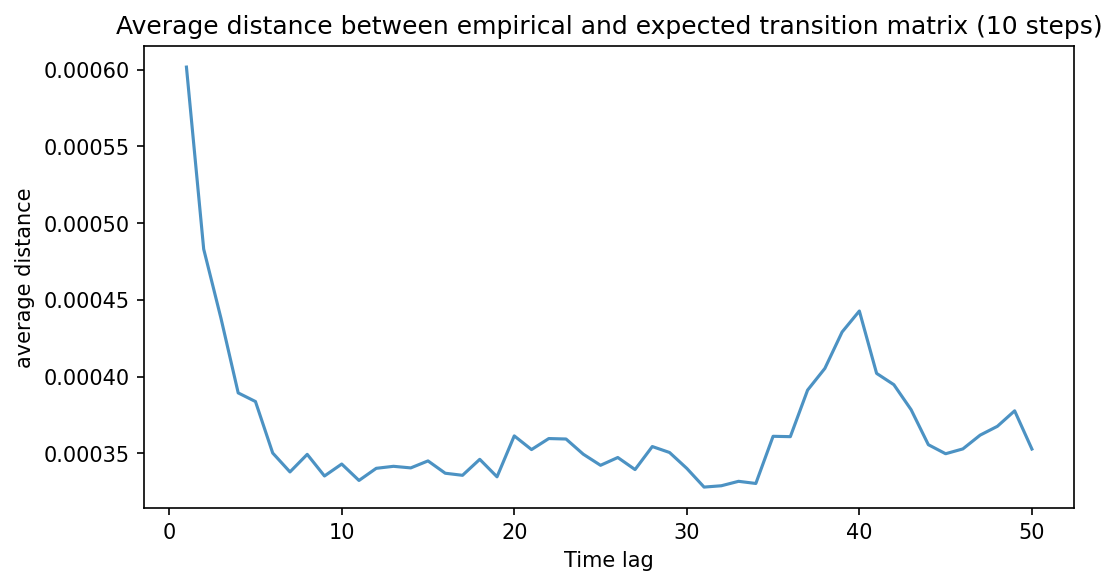

In [24]:
ad = average_distance[:50]
plt.plot(np.arange(len(ad))+1, ad, alpha = 0.8)
plt.xlabel("Time lag")
plt.ylabel("average distance")
_ = plt.title(f"Average distance between empirical and expected transition matrix ({STEPS} steps)")

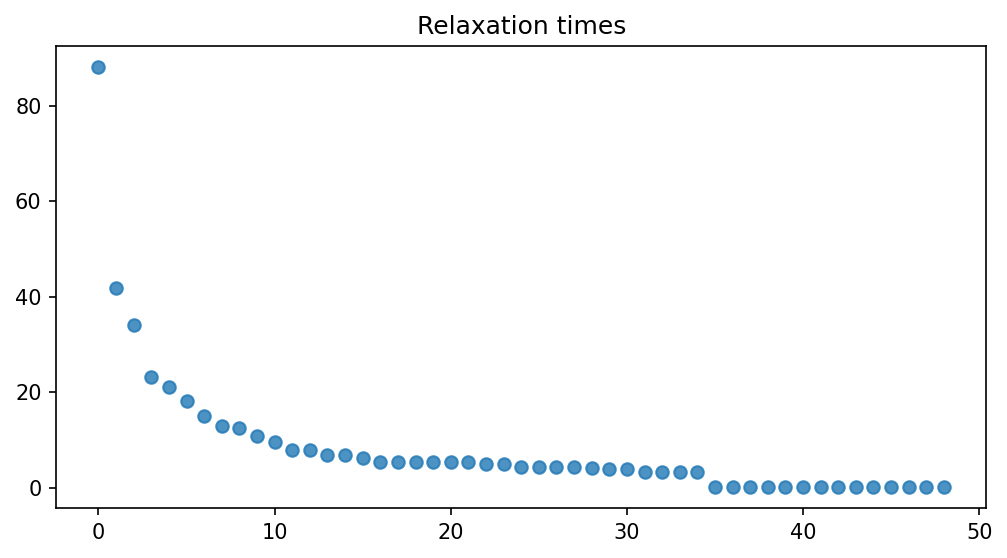

[26  5 26 ... 21 21 21]


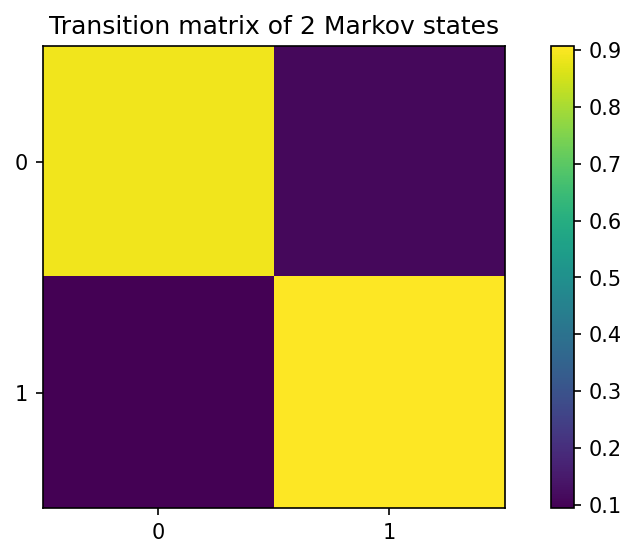

[[0.89 0.11]
 [0.09 0.91]]


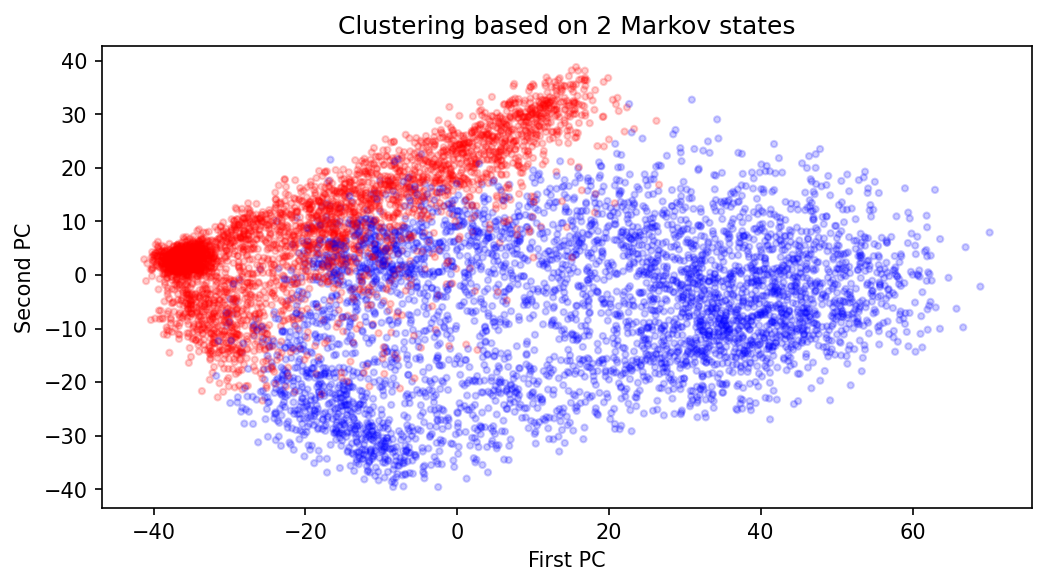

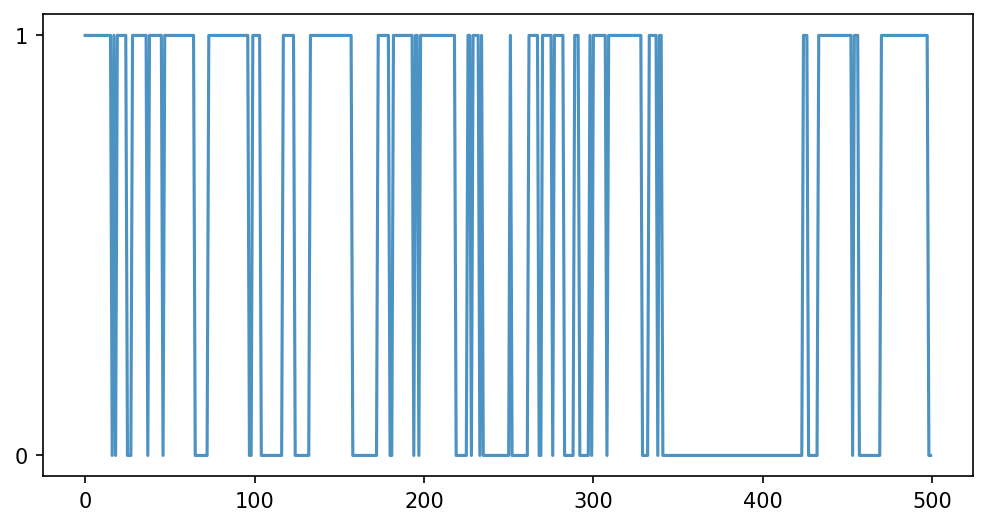

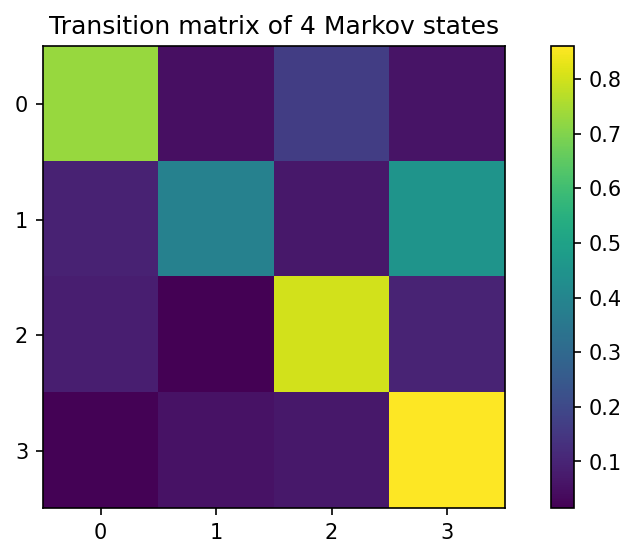

[[0.73 0.05 0.17 0.06]
 [0.1  0.39 0.07 0.45]
 [0.08 0.01 0.8  0.1 ]
 [0.02 0.05 0.07 0.86]]


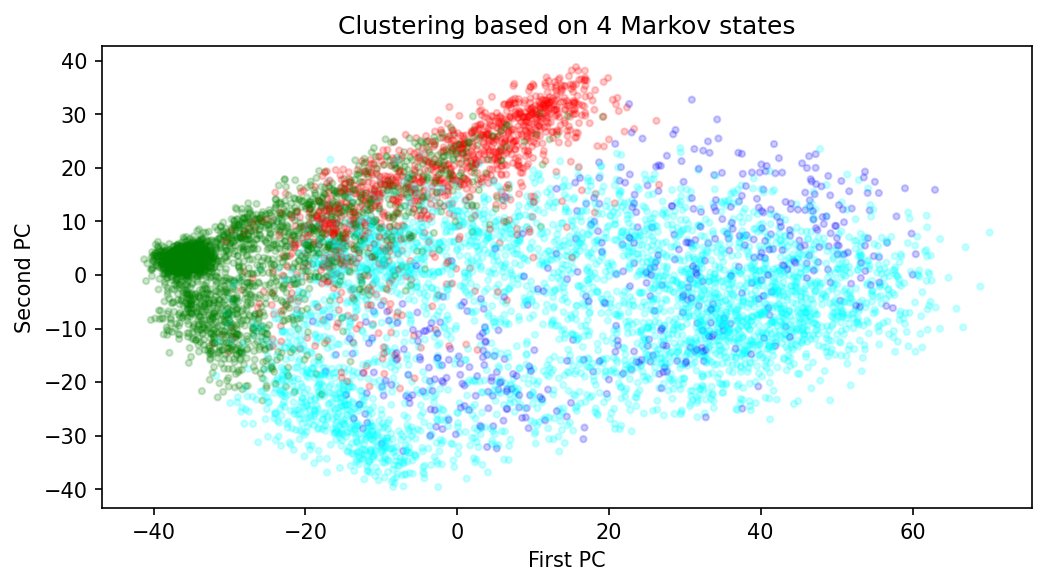

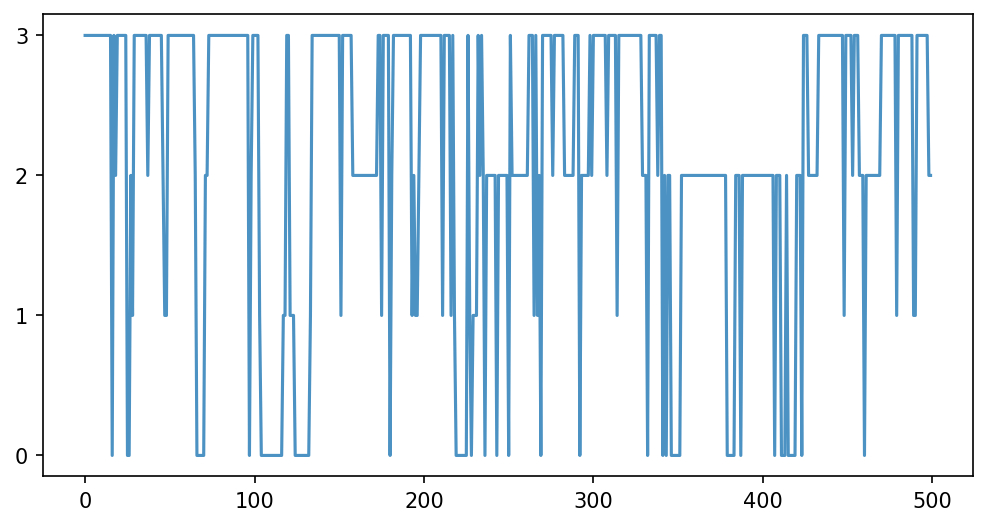

In [25]:
GOOD_TIME_LAG = 15
Markov_state_modelling(X, time_lag = GOOD_TIME_LAG, n_clusters = 50)